# Using deep learning and training data created from user clicks

In [224]:
%matplotlib inline
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

Import training data set from pre-created csv file

In [225]:
dataframe = pd.read_csv("data/auto_training_for_ipy.csv")
train_features = dataframe.ix[:,0:10]
train_labels = dataframe.ix[:,10:11]
train_labels['label'] = train_labels['label'].astype(int)
train_labels['label'] = train_labels['label'].map({-1: 0, 1: 1})

In [226]:
print('features: ', train_features.shape)
print('labels  : ', train_labels.shape)

features:  (2998, 10)
labels  :  (2998, 1)


In [227]:
train_features.head()

,term_score,releaseDate_score,versionNum_score,processingL_score,allPop_score,monthPop_score,userPop_score,spatialR_score,temporalR_score,click_score
0,0.71,-2.780000e+10,2.0,-1,-92,133,-180,109.89,144.0,0
1,1.51,-1.080000e+11,-19.0,1,-314,-99,-892,-389.00,0.0,13
2,1.69,-3.350000e+11,-3.0,0,-27,-47,-402,-108.78,-15108.0,2
3,6.59,9.680000e+09,19.0,1,-8,-73,188,-16.12,5016.0,0
4,2.44,3.970000e+10,-19.0,-1,692,257,567,4.56,-5028.0,-25


In [228]:
train_features.describe()

,term_score,releaseDate_score,versionNum_score,processingL_score,allPop_score,monthPop_score,userPop_score,spatialR_score,temporalR_score,click_score
count,2998.000000,2.998000e+03,2998.000000,2998.000000,2998.000000,2998.000000,2998.000000,2998.000000,2.998000e+03,2998.000000
mean,1.930040,-1.920570e+10,-3.415710,0.101067,-72.448632,-1.579720,-113.866578,-16.695013,-8.413122e+04,3.402935
std,4.392566,2.737896e+11,10.628665,0.935771,475.795673,280.923559,477.643275,1237.701241,6.286458e+05,37.015202
min,-14.230000,-2.890000e+12,-20.000000,-2.000000,-998.000000,-712.000000,-997.000000,-27298.000000,-1.839600e+06,-475.000000
25%,0.330000,-1.910000e+11,-16.000000,-1.000000,-430.000000,-196.750000,-481.000000,-20.560000,-6.480000e+02,0.000000
50%,1.740000,-3.890000e+09,0.000000,0.000000,-56.500000,-4.000000,-95.500000,0.000000,0.000000e+00,0.000000
75%,3.247500,3.920000e+10,0.000000,1.000000,242.000000,187.000000,168.000000,15.885000,1.200000e+01,2.000000
max,13.850000,2.990000e+12,20.000000,3.000000,997.000000,727.000000,999.000000,27283.800000,1.839600e+06,555.000000


Distribution of labels

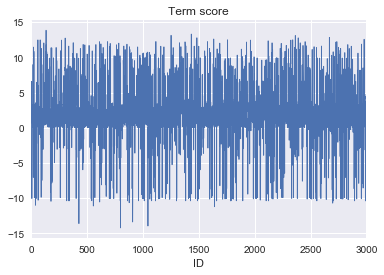

In [229]:
(train_features
     .term_score
     .plot
     .line(lw=0.8))

plt.title('Term score')
plt.xlabel('ID')

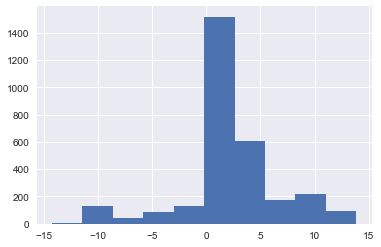

In [230]:
train_features.term_score.hist()

In [231]:
print('mean: ', train_features.mean()[0])
print('var :', train_features.var()[0])

mean:  1.93004002668
var : 19.2946365016


To get a better understanding of the problem domain, take a look at the correlation matrix

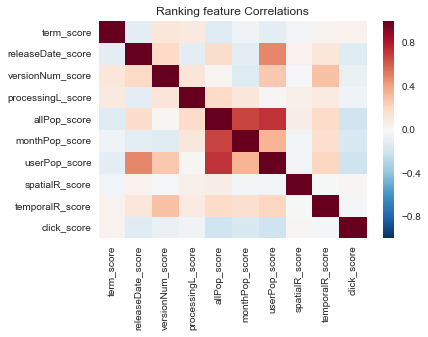

In [232]:
import seaborn as sns
correlations = train_features.corr()
corr_heat = sns.heatmap(correlations)
plt.title('Ranking feature Correlations')

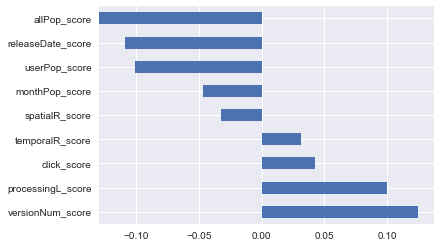

In [233]:
(correlations
     .term_score
     .drop('term_score') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

Import human labelled testing set

In [234]:
dataframe = pd.read_csv("data/humanlabelled_for_ipy.csv")
test_features = dataframe.ix[:,0:10]
test_labels = dataframe.ix[:,10:11]
test_labels['label'] = test_labels['label'].astype(int)
test_labels['label'] = test_labels['label'].map({-1: 0, 1: 1})

In [235]:
from sklearn import preprocessing
# Train data with DL model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import plot_model
from keras.utils import np_utils

Data scaling

In [236]:
scaler = preprocessing.StandardScaler().fit(train_features)
train_features = scaler.transform(train_features)
test_features =  scaler.transform(test_features)
train_labels = np_utils.to_categorical(train_labels, num_classes=2)
test_labels = np_utils.to_categorical(test_labels, num_classes=2)

Build a sequential NN model

In [237]:
model = Sequential()
model.add(Dense(8, input_dim=10, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(4, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [238]:
# train_loss_and_metrics = model.fit(train_features, train_labels, epochs = 5, batch_size = 32)
# print(train_loss_and_metrics)
# test_loss_and_metrics = model.evaluate(test_features, test_labels, batch_size=128)
# print(test_loss_and_metrics)

In [239]:
test_accuracy = [];
test_loss = [];
train_accuracy = [];
train_loss = [];

increment = 64
chunks_train_data = [train_features[x:x+increment] for x in range(0, len(train_features), increment)]
chunks_train_labels = [train_labels[x:x+increment] for x in range(0, len(train_features), increment)]

for epoch in range(0, 2):
    for i, el in enumerate(chunks_train_data):
        print(i)
        train_loss_and_metrics = model.train_on_batch(el, chunks_train_labels[i])
        print(train_loss_and_metrics)
        train_loss.append(train_loss_and_metrics[0])
        train_accuracy.append(train_loss_and_metrics[1])
        test_loss_and_metrics = model.evaluate(test_features, test_labels, batch_size=128)
        print(test_loss_and_metrics)
        test_loss.append(test_loss_and_metrics[0])
        test_accuracy.append(test_loss_and_metrics[1])

0
[0.63056517, 0.625]
23680/29982 [======================>.......] - ETA: 0s [0.71155081455070268, 0.5227469815182707]
1
[0.67252761, 0.5625]
26112/29982 [=========================>....] - ETA: 0s[0.70495569897210109, 0.53862317390036663]
2
[0.69374645, 0.53125]
27264/29982 [==========================>...] - ETA: 0s[0.69997256050338241, 0.54609432325664697]
3
[0.71093482, 0.546875]
24960/29982 [=======================>......] - ETA: 0s

Visualize the learning curve

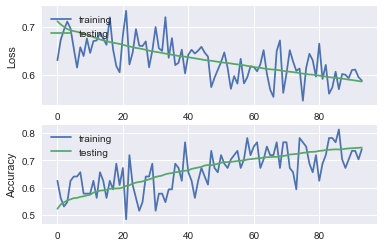

In [240]:
fig = plt.figure()

ax1 = fig.add_subplot(211)
ax1.plot(train_loss)
ax1.plot(test_loss)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Iteration')
ax1.legend(['training', 'testing'], loc='upper left')

ax2 = fig.add_subplot(212)
ax2.plot(train_accuracy)
ax2.plot(test_accuracy)
ax2.set_ylabel('Accuracy')
# ax2.set_xlabel('Iteration')
ax2.legend(['training', 'testing'], loc='upper left')